In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from backtester import Backtest
from binance.client import Client
import datetime
import pandas as pd
import numpy as np
from candle_patterns import candle_df
from dotenv import dotenv_values


In [2]:
config = dotenv_values(".env") 

In [3]:
client = Client(config.get('KEY'), config.get('SECKET_KEY'))

In [4]:
DAYS = 90
TICKER = "BTCUSDT"
end = datetime.datetime.now()
end = end - datetime.timedelta(days=0)
start = end - datetime.timedelta(days=DAYS)
end = end.strftime('%d %b, %Y')
start = start.strftime('%d %b, %Y')
klines = client.get_historical_klines(TICKER, Client.KLINE_INTERVAL_5MINUTE, start, end)
data = pd.DataFrame(data=[row[1:7] for row in klines],
                    columns=[
    "open", "high", "low", "close", "volume", "time"]
).set_index("time")
data.index = pd.to_datetime(data.index + 1, unit='ms')
data = data.sort_index()
data = data.apply(pd.to_numeric, axis=1)

In [5]:
## Make candle
data = candle_df(data)

In [6]:
data.head(1)

,open,high,low,close,volume,candle_score,candle_pattern,candle_cumsum
time,,,,,,,,
2021-01-31 00:05:00,34262.89,34300.0,34003.0,34292.22,471.390558,0,,NaN


### PART 1

## Analyse candle

In [7]:
CANDLE = 'bearish_harami'
data['event'] = data['candle_pattern'].str.contains(CANDLE)
data[data['event'] == True]['event'].value_counts()

True    2493
Name: event, dtype: int64

## Backtest strategy

<AxesSubplot:xlabel='time'>

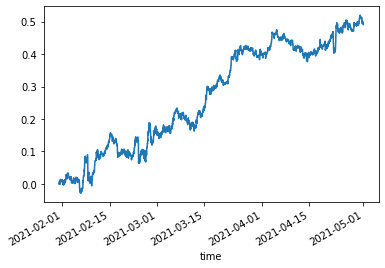

In [8]:
back = Backtest()
data['signal'] = np.where(data['event'] == True, -1, 0) # if -1 = bearish, if 1 = bullish
returns = back.exit_by_lag(data=data, take_profit=0.005, stop_loss=-0.005, lag=5, comission=0)
returns['cumsum'].plot()


## Statistics test

KstestResult(statistic=0.49227530736062564, pvalue=0.0)


<AxesSubplot:>

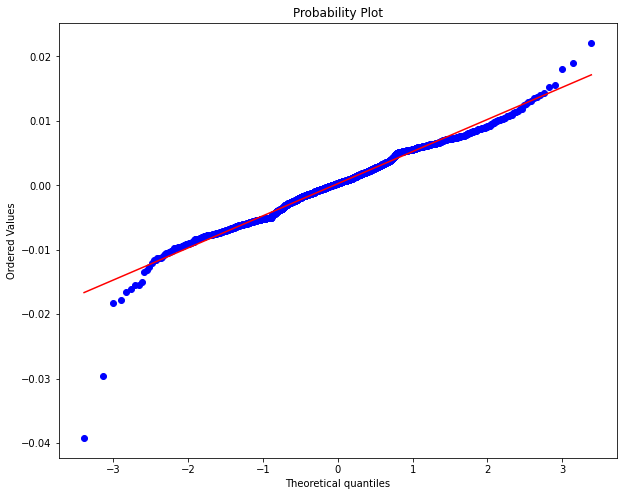

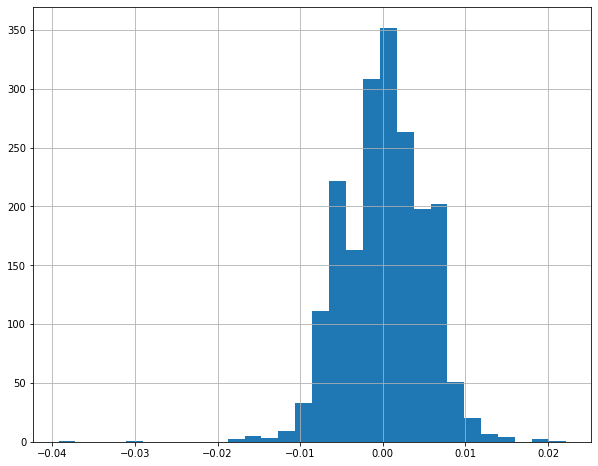

In [9]:
'''
The Kolmogorov-Smirnov test can evaluate whether a distribution is normal. It provides us with a p-value. If this value is significant (< 0.05), then the data is not normal:
'''
print(stats.kstest(returns[returns['return'] != 0]['return'], cdf="norm"))
fig, ax = plt.subplots(figsize=(10, 8))
stats.probplot(returns[returns['return'] != 0]['return'], plot=ax)
fig, ax = plt.subplots(figsize=(10, 8))
returns[returns['return'] != 0]['return'].hist(ax=ax, bins=30)

In [21]:
stats_st = stats.kstest(returns[returns['return'] != 0]['return'], cdf="norm")
print(stats_st.pvalue)

0.0


In [10]:
# Analyse disttibution of returns
returns[returns['return'] != 0]['return'].describe()

count    1958.000000
mean        0.000251
std         0.005040
min        -0.039232
25%        -0.002952
50%         0.000328
75%         0.003650
max         0.022143
Name: return, dtype: float64

### PART 2

In [11]:
## Analyse candles power in time serires. Becouse we have onother releationship
LAG = 20
data['lag'] = data['close'].shift(-LAG).pct_change()
data.groupby('candle_cumsum').lag.agg(['mean', 'std'])

,mean,std
candle_cumsum,,
-4.0,-2.590526e-03,0.003166
-3.0,7.453138e-05,0.003433
-2.0,9.359418e-06,0.003437
-1.0,-4.228737e-05,0.002801
0.0,6.091752e-05,0.002798
1.0,-2.063158e-07,0.002847
2.0,6.356020e-05,0.002775
3.0,1.748592e-04,0.002820
4.0,-2.113801e-05,0.002778


 0    0.538214
 1    0.216146
-1    0.199636
 2    0.029843
-2    0.007906
 3    0.005658
 4    0.002597
Name: candle_score, dtype: float64


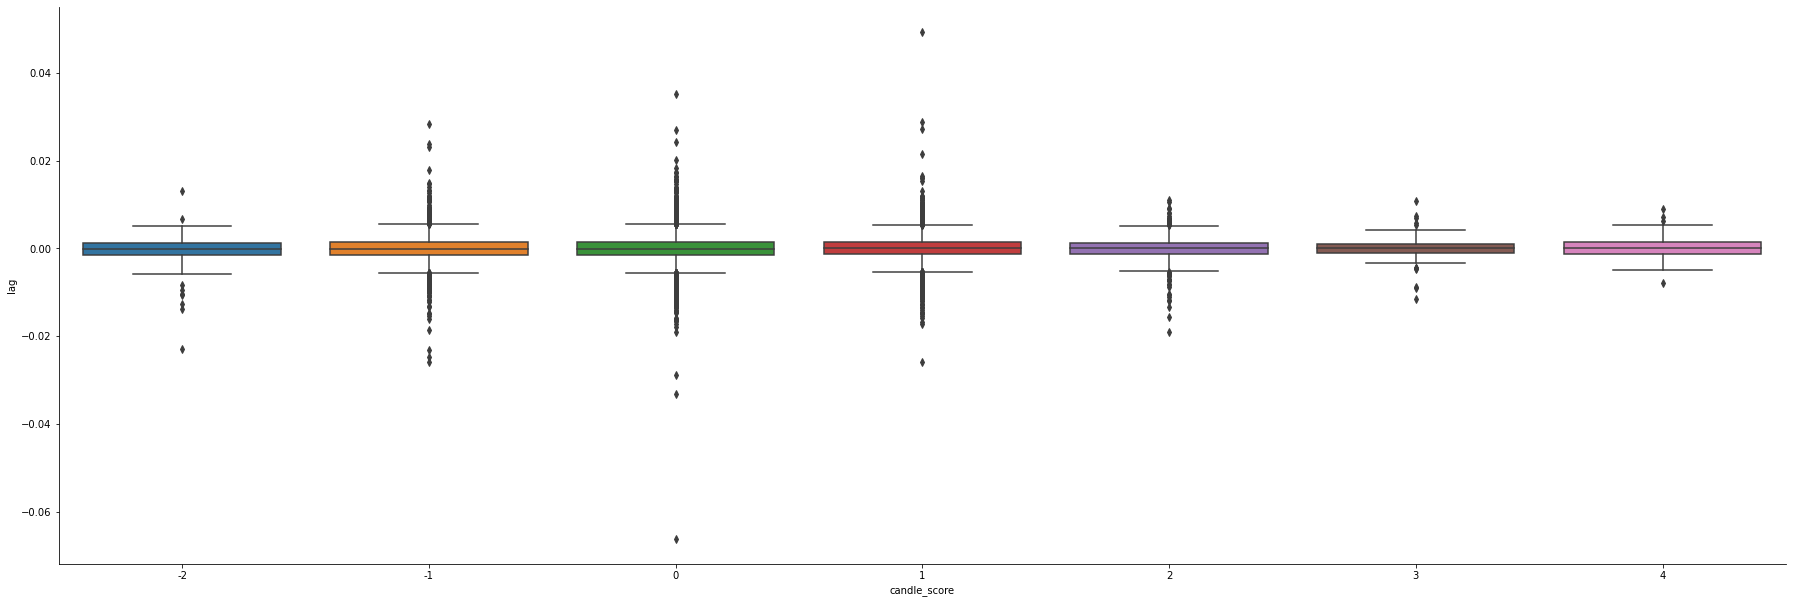

In [12]:
print(data['candle_score'].value_counts(normalize=True))
g = sns.catplot(
    x="candle_score", y="lag", data=data, kind="box", height=8.27, aspect=15/5
)


 0.0    0.372441
 1.0    0.270301
-1.0    0.202735
 2.0    0.083481
-2.0    0.033609
 3.0    0.025419
 4.0    0.007610
-3.0    0.002743
 5.0    0.001236
 6.0    0.000309
-4.0    0.000077
 7.0    0.000039
Name: candle_cumsum, dtype: float64